<a href="https://colab.research.google.com/github/pranaysathish/alzheimer-detection-dashboard/blob/main/alzheimer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"pranayjsathish","key":"4932f5eb273bc289dd4fae5366f00cf0"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ninadaithal/imagesoasis
!unzip imagesoasis.zip -d /content/oasis_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: /content/oasis_dataset/Data/Very mil

In [3]:
# Define the path to your dataset directory
dataset_path = '/content/oasis_dataset/Data/'

# List of categories
categories = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

# Check the number of images in each category
for category in categories:
    folder_path = os.path.join(dataset_path, category)
    print(f"{category}: {len(os.listdir(folder_path))} images")


Non Demented: 67222 images
Very mild Dementia: 13725 images
Mild Dementia: 5002 images
Moderate Dementia: 488 images


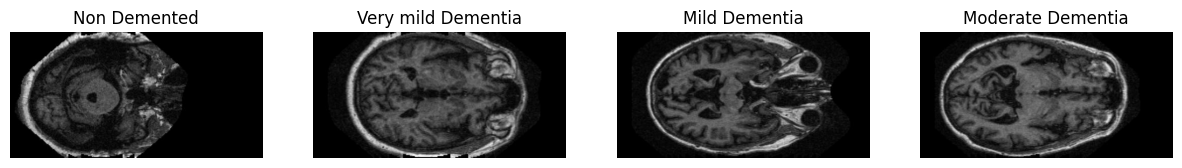

In [4]:
# Function to load and display sample images from each category
def display_sample_images(categories, dataset_path):
    fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))
    for i, category in enumerate(categories):
        # Load a sample image
        sample_image_path = glob(os.path.join(dataset_path, category, '*.jpg'))[0]  # Adjust the extension if necessary
        sample_image = cv2.imread(sample_image_path)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

        # Plot the image
        axes[i].imshow(sample_image)
        axes[i].set_title(category)
        axes[i].axis('off')

display_sample_images(categories, dataset_path)


In [5]:
# Parameters
IMG_SIZE = 128  # Image size for resizing
BATCH_SIZE = 32  # Batch size for data generator
dataset_path = '/content/oasis_dataset/Data'  # Update this to your dataset path

# Categories (Ensure these match the folder names exactly in your dataset)
categories = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']


In [7]:
# Data generator for rescaling and splitting
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values between 0 and 1
    validation_split=0.3       # 70% train, 30% validation/test split
)

# Train data generator (70% of data)
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',         # Use the 'training' subset for training
    shuffle=True
)

# Validation data generator (30% of data, for validation and testing)
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',       # Use the 'validation' subset for validation
    shuffle=False
)


Found 60508 images belonging to 4 classes.
Found 25929 images belonging to 4 classes.


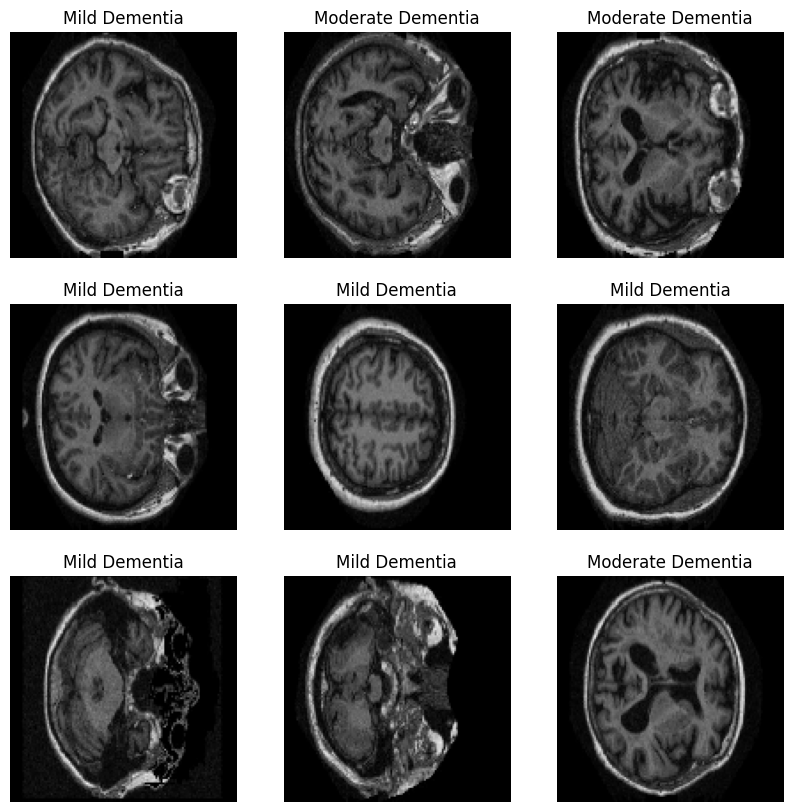

In [8]:
# Function to plot a few images from the generator
def plot_images_from_generator(generator):
    x_batch, y_batch = next(generator)  # Get a batch of images and labels
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display first 9 images in the batch
        plt.subplot(3, 3, i+1)
        plt.imshow(x_batch[i])
        plt.title(categories[np.argmax(y_batch[i])])
        plt.axis('off')
    plt.show()

# Display sample images from the training generator
plot_images_from_generator(train_generator)

# **Building the Baseline CNN Model**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [10]:
# Define the CNN model
model = Sequential()

# Convolutional layers with ReLU activations and max pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to reduce overfitting
model.add(Dense(len(categories), activation='softmax'))  # Output layer with softmax for multi-class classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=5,                  # Stop training after 5 epochs of no improvement
    restore_best_weights=True     # Restore the best weights when stopping
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',           # Save the best model in Keras format
    monitor='val_accuracy',       # Monitor validation accuracy
    save_best_only=True           # Only save the model if the monitored quantity improves
)

In [15]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # You can adjust the learning rate as needed
    loss='categorical_crossentropy',        # Use categorical crossentropy for multi-class classification
    metrics=['accuracy']                     # Monitor accuracy
)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,                             # You can adjust the number of epochs
    callbacks=[early_stopping, model_checkpoint]  # Include callbacks
)

Epoch 1/20
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 150s 78ms/step - accuracy: 0.8000 - loss: 0.5531 - val_accuracy: 0.7684 - val_loss: 0.7753
Epoch 2/20
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 166s 59ms/step - accuracy: 0.9239 - loss: 0.1981 - val_accuracy: 0.7701 - val_loss: 1.2252
Epoch 3/20
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 116s 61ms/step - accuracy: 0.9748 - loss: 0.0763 - val_accuracy: 0.7739 - val_loss: 1.7432
Epoch 4/20
1377/1891 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9849 - loss: 0.0438

# **Evaluate the Model**

In [ ]:
# Load the best saved model after training
best_model = load_model('best_model.keras')

# Evaluate on the validation set
val_loss, val_accuracy = best_model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


# **Visualize Training History**


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()
